<a href="https://colab.research.google.com/github/Charlotte-99/Y3Project/blob/main/CNN_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A Convolutional Neural Network for Classifying Non-Augmented and Augmented CMB Maps

This notebook is divided into three sections:


1.   Importing and formatting the data
2.   Building a pipeline and creating a CNN model
3.   Analysing the results



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential

In [ ]:
# Change directory
os.chdir('drive/MyDrive/Project')

FileNotFoundError: ignored

## Importing and formatting the data
Below, we import our 1000 CMB and 500 string cutouts. The CMB cutouts were generated by extracting 20 cutouts from each of 50 full-sky maps, whereas the 500 string cutouts were generated from 3 full-sky maps.

In [ ]:
# Import data
cmb = np.load('cmb_1000_extracts.npy')
string = np.concatenate([np.load('string_map_extracts_1.npy'),
                         np.load('string_map_extracts_2.npy'),
                         np.load('string_map_extracts_3.npy')])

# Add channel dimension
cmb = cmb[..., np.newaxis]
string = string[..., np.newaxis]

print(cmb.shape)
print(string.shape)

(1000, 200, 200, 1)
(500, 200, 200, 1)


We will split the data into three different groups:


1.   Training set - this will be used to train our model. It will use 500 cmb maps and 250 string maps.
2.   Validation set - this will be used during training to check performance on unseen maps. It will contain 250 cmb maps and 125 string maps.
3. Test set - this will kept separate from training as a final check on our model's performance. It will contain 250 cmb maps and 125 string maps.

We will use the same labelling scheme as before: '0' for no string augmentations and '1' for string augmentations.

First, we will shuffle our arrays.

In [ ]:
# Shuffle cmb and string maps using different seeds.
np.random.shuffle(cmb)
np.random.shuffle(string)

Here, we create the training set by taking the first 500 and 250 images from the string and cmb map arrays, respectively.

In [ ]:
# Slice cmb array
X_train_cmb = cmb[:500]

# Slice string array and also add placeholder string arrays for the cmb maps
# that we won't augment
nan_string = np.empty(shape=(250, 200, 200, 1))
nan_string[:] = np.NaN
X_train_string = np.concatenate([nan_string, string[:250]])

# Label data
y_train = np.concatenate([np.zeros(250), np.ones(250)])

# Shuffle all arrays with same seed
np.random.RandomState(7).shuffle(X_train_cmb)
np.random.RandomState(7).shuffle(X_train_string)
np.random.RandomState(7).shuffle(y_train)

print(X_train_cmb.shape)
print(X_train_string.shape)
print(y_train.shape)

(500, 200, 200, 1)
(500, 200, 200, 1)
(500,)


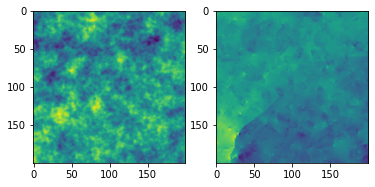

In [ ]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(X_train_cmb[0].reshape(200, 200))
ax[1].imshow(X_train_string[0].reshape(200, 200))

Then, we create the validation set. These arrays will not undergo augmentations on the fly, so we will create the augmented CMB maps through a straight addition with the by some multiplicative constant, $\alpha$. 

Our string maps' colour scale gives a measure of $\frac{\Theta}{GU}$. The multiplicative constant we use will give an indication of the string tension.

In [ ]:
# Slice cmb array
X_val_cmb = cmb[500:750]

# Slice string array
X_val_string = string[250:375]

# Create array split into two classes; first half of array will have no augmentations
alpha = 1e-6
X_val = np.concatenate([X_val_cmb[:125],
                        X_val_cmb[125:] + alpha*X_val_string])

# Create labels
y_val = np.concatenate([np.zeros(125), np.ones(125)])

# Shuffle X_val, y_val with same seed
np.random.RandomState(14).shuffle(X_val)
np.random.RandomState(14).shuffle(y_val)

print(X_val.shape)
print(y_val.shape)

(250, 200, 200, 1)
(250,)


We do the same and generate our test set.

In [ ]:
# Slice cmb array
X_test_cmb = cmb[750:]

# Slice string array
X_test_string = string[375:]

# Create array split into two classes; first half of array will have no augmentations
alpha = 1e-6
X_test = np.concatenate([X_test_cmb[:125],
                        X_test_cmb[125:] + alpha*X_test_string])

# Create labels
y_test = np.concatenate([np.zeros(125), np.ones(125)])

# Shuffle X_val, y_val with same seed
np.random.RandomState(28).shuffle(X_test)
np.random.RandomState(28).shuffle(y_test)

print(X_test.shape)
print(y_test.shape)

(250, 200, 200, 1)
(250,)


Below, we plot some images from our validation and test sets. 

0.0
1.0
0.0
1.0


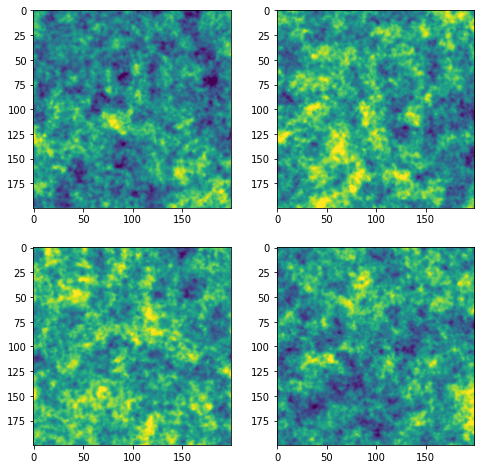

In [ ]:
print(y_val[0])
print(y_val[2])

print(y_test[0])
print(y_test[5])

fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes[0, 0].imshow(X_val[0].reshape(200, 200), vmin=-300e-6, vmax=300e-6)
axes[0, 1].imshow(X_val[2].reshape(200, 200), vmin=-300e-6, vmax=300e-6)
axes[1, 0].imshow(X_test[0].reshape(200, 200), vmin=-300e-6, vmax=300e-6)
axes[1, 1].imshow(X_test[5].reshape(200, 200), vmin=-300e-6, vmax=300e-6)

## Building the pipeline and CNN model

In this section we will build the pipeline and CNN. First we introduce three functions: two types of batch normalisation functions and another function that will perform random string augmentations on the fly on our training set.

In [ ]:
def batch_standardisation(maps, labels):
  epsilon = 0.0001
  mean, variance = tf.nn.moments(maps, axes=[0, 1, 2])
  maps_standardised = (maps - mean)/(variance + epsilon)
  return maps_standardised, labels  

In [ ]:
def batch_normalisation(maps, labels):
  min_val = tf.math.reduce_min(maps)
  max_val = tf.math.reduce_max(maps)
  denom = max_val - min_val
  maps_normalised = (maps - min_val)/denom
  return maps_normalised, labels

In [ ]:
def selective_string_maps(string_map, cmb_map, label):
  # label value
  N = np.int(label)

  # Transformation: rotate CMB map
  # Output: rotated CMB map and original label
  def rotation():
    cmb_rot = tf.image.rot90(cmb_map, tf.random.uniform(shape=[], minval=0,
                                          maxval=4, dtype=tf.int32))
    return cmb_rot, label

  # Transformation: introduce discontinuities to CMB map
  # Output: discontinuity map and original label
  def add_string():
    alpha = 1e-6
    string_rot = tf.image.rot90(string_map, tf.random.uniform(shape=[], minval=0,
                                maxval=4, dtype=tf.int32))
    string_scaled = tf.multiply(string_rot, alpha)
    cmb_rot = tf.image.rot90(cmb_map, tf.random.uniform(shape=[], minval=0,
                            maxval=4, dtype=tf.int32))
    aug_cmb = tf.add(cmb_rot, string_scaled)
    return aug_cmb, label

  return tf.cond(N == 0, true_fn=rotation, false_fn=add_string)

We may now define our CNN model.

In [ ]:
# Build model
def build_model():
  model = Sequential([Conv2D(32, 3, activation='relu'),
                      Conv2D(32, 3, activation='relu'),
                      MaxPooling2D(5),
                      Flatten(),
                      Dense(128, activation='relu'),
                      Dense(2, activation='softmax')
                      ])
  optimizer = tf.keras.optimizers.Adam(0.001)
  model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=tf.keras.metrics.SparseCategoricalAccuracy())
  return model

And finally we build our pipelines and test our CNN model. We can use either one of the batch functions.

In [ ]:
# Create datasets
train_ds = tf.data.Dataset.from_tensor_slices((X_train_string, X_train_cmb, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# Train dataset pipeline
train_ds = train_ds.map(selective_string_maps)
train_ds = train_ds.shuffle(60)
train_ds = train_ds.batch(64)
train_ds = train_ds.map(batch_standardisation)
train_ds = train_ds.prefetch(1)

# Validation dataset pipeline
val_ds = val_ds.batch(64)
val_ds = val_ds.map(batch_standardisation)
val_ds = val_ds.prefetch(1)

# Test dataset pipeline
test_ds = test_ds.batch(64)
test_ds = test_ds.map(batch_standardisation)
test_ds = test_ds.prefetch(1)

model = build_model()

history = model.fit(train_ds, epochs=20, verbose=1, validation_data=val_ds)
print(model.summary())

Epoch 1/20
8/8 [==============================] - 2s 150ms/step - loss: 5.2150 - sparse_categorical_accuracy: 0.4655 - val_loss: 0.8521 - val_sparse_categorical_accuracy: 0.5000
Epoch 2/20
8/8 [==============================] - 1s 130ms/step - loss: 0.7443 - sparse_categorical_accuracy: 0.5147 - val_loss: 0.7428 - val_sparse_categorical_accuracy: 0.5000
Epoch 3/20
8/8 [==============================] - 1s 127ms/step - loss: 0.7174 - sparse_categorical_accuracy: 0.5107 - val_loss: 0.6948 - val_sparse_categorical_accuracy: 0.5000
Epoch 4/20
8/8 [==============================] - 1s 127ms/step - loss: 0.6942 - sparse_categorical_accuracy: 0.4993 - val_loss: 0.6932 - val_sparse_categorical_accuracy: 0.5000
Epoch 5/20
8/8 [==============================] - 1s 121ms/step - loss: 0.6926 - sparse_categorical_accuracy: 0.5061 - val_loss: 0.6931 - val_sparse_categorical_accuracy: 0.5000
Epoch 6/20
8/8 [==============================] - 1s 127ms/step - loss: 0.6927 - sparse_categorical_accuracy: 

## Analysis of results

Here, we look at the feature maps. To do this, we will use a normalised map (note that this normalisation will depend on the entire dataset whereas before we were using batch normalisation).

In [ ]:
epsilon = 0.0001
mean = np.mean(X_val, axis=(0, 1, 2))
variance = np.var(X_val, axis=(0, 1, 2))

X_val_norm = (X_val - mean)/(variance + epsilon)

1.0
[1]


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


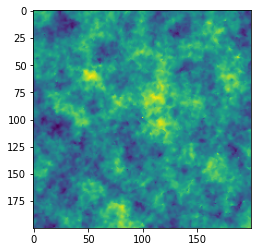

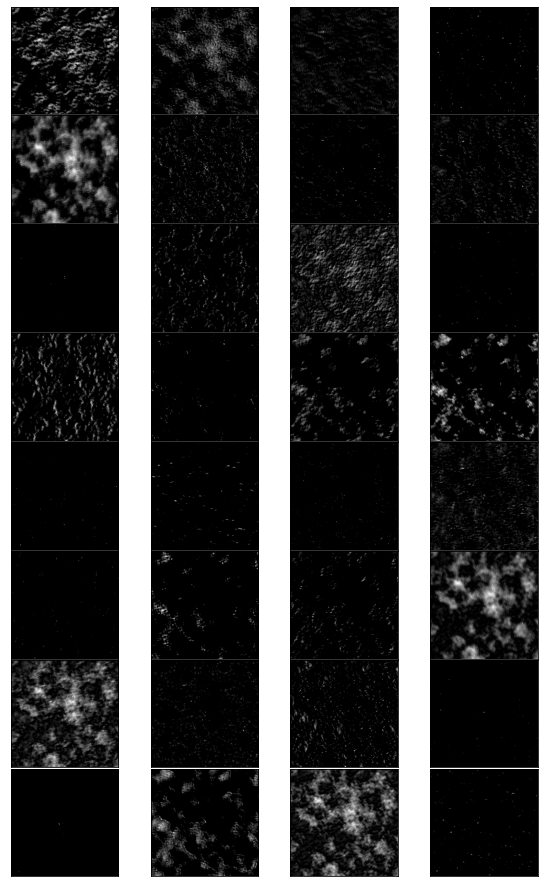

In [ ]:
# Just want to see what the filters see

visual_model = tf.keras.models.Model(inputs=model.inputs,
                                     outputs=model.layers[1].output)

n = 10
array = X_val_norm[n].reshape(1, 200, 200, 1)
print(y_val[n])
print(model.predict_classes(array))

plt.imshow(array.reshape(200, 200))
feature_maps = visual_model.predict(array)

fig, axes = plt.subplots(8, 4, figsize=(10, 16))
for i, ax in enumerate(axes.flat):
  ax.set_xticks([])
  ax.set_yticks([])
  ax.imshow(feature_maps[0, :, :, i], cmap='gray')

plt.subplots_adjust(wspace=0.01, hspace=0.01)